# 使用虛構的價格模型，嘗試使用機器學習方法找出影響股價預測的特徵！
另一個世界(豬老三的世界）股價生成邏輯

本模型並非用於模擬真實金融市場，而是 ABu 量化框架中
為了測試策略魯棒性而設計的「合成市場」。它利用前兩天的
量價行為推導今日收盤價，形成具備市場情緒與波動特性的
平行世界價格序列。

演算法邏輯：
----------------

1. 使用資料
   - 前天收盤價與成交量 (c2, v2)
   - 昨天收盤價與成交量 (c1, v1)
   - 今天成交量 (v_today)
   - 今天是星期幾（0=週一 ... 4=週五）

2. 今日漲跌方向判斷（模型特性，非市場理論）
   - 若價格變化方向與成交量變化同向 → 設為看漲
       價漲量增 或 價跌量縮 → sign = +1
   - 若價格與成交量背離 → 設為看跌
       價漲量縮 或 價跌量增 → sign = -1

   ※ 此規則為示範用途，不代表真實量價關係

3. 週期情緒修正（需今日量為三日最大）
   - 若今天為週五 → 偏空（獲利了結） sign = -1
   - 若今天為週一 → 偏多（資金回流） sign = +1

4. 今日波動幅度
   - 基礎幅度 = |c1 - c2|
   - 量能放大因子 =
       mean(v_today / v1, v_today / v2)
   - 估算變動金額 = 基礎幅度 × 量因子

5. 風險限制（漲跌停防護）
   - 若變動超過昨日收盤 10%
     → 限制為 ±10%

6. 今日收盤價
   today_close = c1 + sign × min(raw_move, limit)

模型特性：
-----------
- 價格變動受過去量價互動驅動
- 具週期性市場情緒（週一偏多、週五偏空）
- 大量 → 大波動，小量 → 小波動
- 非隨機漫步，具策略可測試性
- 長期可能因使用絕對價差推算而衰減至低價

In [1]:
from alanq.data import StockDataManager

symbols = ["TSLA", "MSFT", "AAPL"]

data_manager = StockDataManager(symbols, start_date="2021-01-01")
real_stock_data = data_manager.get_stock_data()
real_stock_data['TSLA'].head(3)

正在使用 yfinance 下載 3 檔股票資料...
------------------------------
已成功下載 3 檔股票資料
  - TSLA: 1229 筆資料，日期範圍 2021-01-04 至 2025-11-21
  - MSFT: 1229 筆資料，日期範圍 2021-01-04 至 2025-11-21
  - AAPL: 1229 筆資料，日期範圍 2021-01-04 至 2025-11-21
------------------------------


Price,Close,High,Low,Open,Volume
Date,,,,,
2021-01-04,243.256668,248.163330,239.063339,239.820007,145914600
2021-01-05,245.036667,246.946671,239.733337,241.220001,96735600
2021-01-06,251.993332,258.000000,249.699997,252.830002,134100000


In [2]:
# 將真實世界的股價調整成虛構的股價模型
import numpy as np
import pandas as pd
from datetime import datetime

def gen_another_world_price_rule(
        yesterday_close, yesterday_volume,
        bf_yesterday_close, bf_yesterday_volume,
        today_volume, date_week):
    """
    根據 ABu 原書邏輯生成另一個世界的今日收盤價

    核心規則（阿布原版）：
    1️⃣ 看昨日與前日的價格 & 成交量變動方向
        - 價↑量↑ → 漲
        - 價↓量↓ → 漲
        - 其他 → 跌
    2️⃣ 如果今日量最大 → 加噪音
        - 並且今天是星期五(4) → 跌
        - 並且今天是星期一(0) → 漲
    3️⃣ 涨跌幅度 = |昨日-前日| × 量比
        - 若超過 ±10% → 限制
    """

    price_change = yesterday_close - bf_yesterday_close
    volume_change = yesterday_volume - bf_yesterday_volume

    # 價量同向 → 漲，否則跌
    sign = 1.0 if price_change * volume_change > 0 else -1.0

    # 今天量是否為三日最大
    gen_noise = today_volume > max(yesterday_volume, bf_yesterday_volume)

    # 量最大且為星期五 → 跌
    if gen_noise and date_week == 4:
        sign = -1.0
    # 量最大且為星期一 → 漲
    elif gen_noise and date_week == 0:
        sign = 1.0

    price_base = abs(price_change)

    # 量比（今日VS昨日、今日VS前日）
    price_factor = np.mean([
        today_volume / yesterday_volume,
        today_volume / bf_yesterday_volume
    ])

    # 計算今日漲跌金額
    raw_move = price_base * price_factor

    # 限制漲跌幅度不超過 ±10%
    max_move = yesterday_close * 0.10
    raw_move = min(raw_move, max_move)

    return yesterday_close + sign * raw_move


def convert_to_another_world(df: pd.DataFrame):
    """
    將 Yahoo Finance DataFrame 轉換為阿布的「另一個世界」價格版本

    df 需包含：
        Close, Volume
    """

    df = df.copy()

    # 建立星期欄位（0=Mon, 4=Fri）
    df["date_week"] = df.index.weekday

    # 只保留必要欄位
    df = df[["Close", "Volume", "date_week"]]

    # 從第 3 天開始重算價格
    closes = df["Close"].values
    vols = df["Volume"].values
    weekdays = df["date_week"].values

    for i in range(2, len(df)):
        closes[i] = gen_another_world_price_rule(
            closes[i-1], vols[i-1],
            closes[i-2], vols[i-2],
            vols[i], weekdays[i]
        )

    df["Close"] = closes
    return df

def build_another_world_dataset(real_stock_data: dict):
    """
    real_stock_data 格式：
    {
        "TSLA": df,
        "MSFT": df,
        "AAPL": df,
    }

    回傳相同結構，但價格已變成另一個世界
    """

    synthetic = {}

    for symbol, df in real_stock_data.items():
        synthetic[symbol] = convert_to_another_world(df)

    return synthetic



Price            Close     Volume  date_week
Date                                        
2021-01-04  243.256668  145914600          0
2021-01-05  245.036667   96735600          1
2021-01-06  242.984966  134100000          2


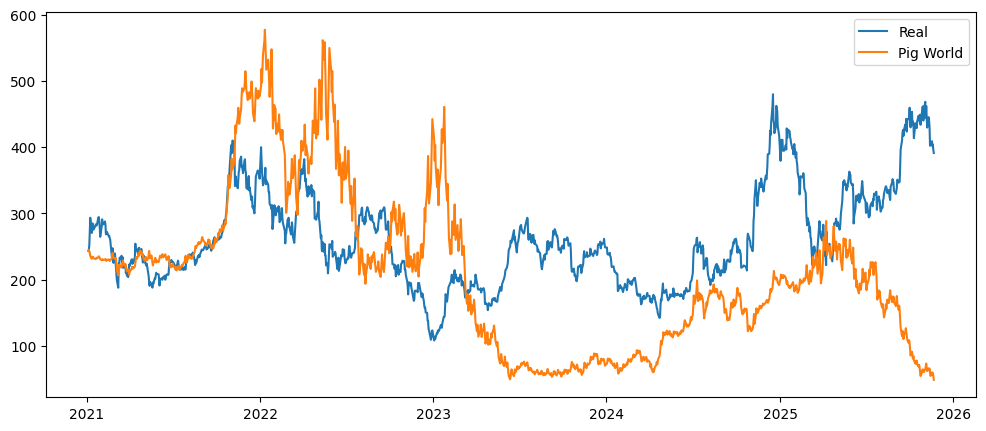

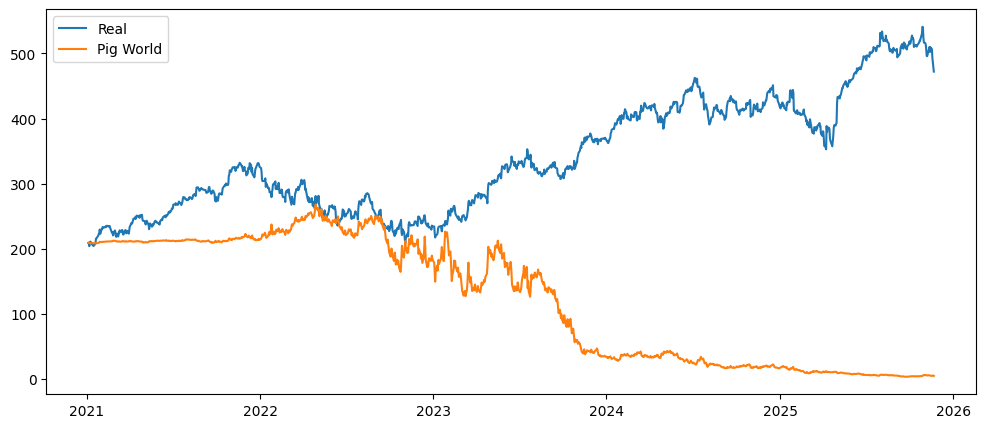

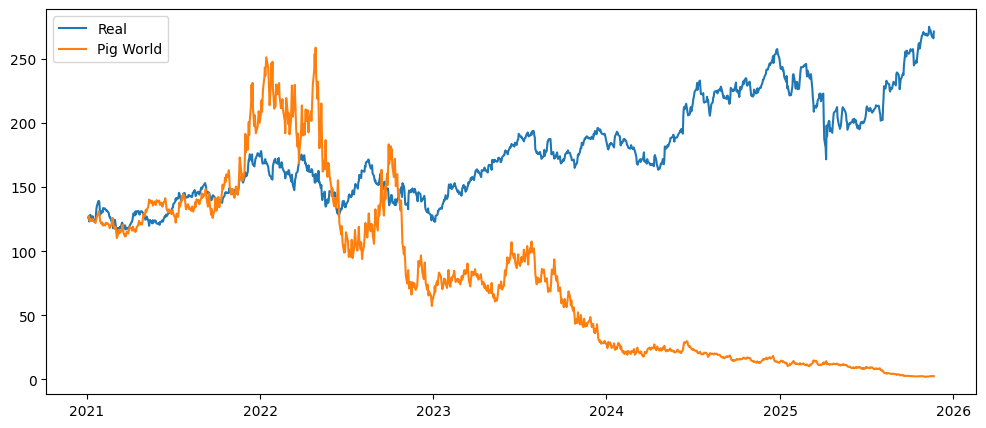

In [3]:
# 合成有漲跌規則的虛假股票資料
pig_three_stock_data = build_another_world_dataset(real_stock_data)

print(pig_three_stock_data['TSLA'].head(3))

# 看一下跟真實資料的趨勢差別
import matplotlib.pyplot as plt

for symbol in symbols:
    plt.figure(figsize=(12,5))
    plt.plot(real_stock_data[symbol]["Close"], label="Real")
    plt.plot(pig_three_stock_data[symbol]["Close"], label="Pig World")
    plt.legend()
    plt.show()


# 建立機器學習特徵

In [4]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

def gen_pig_three_feature(df: pd.DataFrame) -> pd.DataFrame:
    """
    將「另一個世界」的股價 DataFrame 轉成機器學習可用的特徵表

    需求欄位：
        - Close: 收盤價（已經是另一個世界生成的價格）
        - Volume: 成交量
        - date_week: 星期（0=週一...4=週五），若不存在會自動由 index 建立

    回傳：
        - DataFrame，只保留 regress_y + feature_* 欄位，且去掉前兩天無法對齊的列
    """

    # 先 copy 一份，避免修改到原始 df
    kl_another_word = df.copy()

    # 如果沒有 date_week 欄位（像你用 StockDataManager 的情況），就用 index.weekday 自動建立
    if 'date_week' not in kl_another_word.columns:
        kl_another_word['date_week'] = kl_another_word.index.weekday

    # 統一欄位名稱：阿布原版用的是 'close', 'volume' 小寫，這裡我們對應一下
    # 如果你的 df 用的是大寫 Close/Volume，就建立一份小寫別名欄位
    if 'close' not in kl_another_word.columns:
        kl_another_word['close'] = kl_another_word['Close']
    if 'volume' not in kl_another_word.columns:
        kl_another_word['volume'] = kl_another_word['Volume']

    # --------------------------------------------------------
    # 1️⃣ 建立 y 值：使用今日相對昨日的漲跌幅（報酬率）
    # --------------------------------------------------------
    # pct_change() = (今日收盤 - 昨日收盤) / 昨日收盤
    kl_another_word['regress_y'] = kl_another_word['close'].pct_change()

    # --------------------------------------------------------
    # 2️⃣ 建立「前天 / 昨天」的價格與成交量欄位（滯後特徵）
    # --------------------------------------------------------

    # 先建立欄位，預設為 0（之後再用對齊方式填入）
    kl_another_word['bf_yesterday_close'] = 0.0   # 前天收盤價
    kl_another_word['yesterday_close'] = 0.0      # 昨天收盤價
    kl_another_word['yesterday_volume'] = 0.0     # 昨天成交量
    kl_another_word['bf_yesterday_volume'] = 0.0  # 前天成交量

    # 對齊規則：
    #  - bf_yesterday_*：今天這一列要看到「兩天前」的數值 → [2:] = [:-2]
    #  - yesterday_*：   今天這一列要看到「昨天」的數值   → [1:] = [:-1]

    # 前天收盤價：從第 3 天開始，每天對應兩天前的 close
    kl_another_word.loc[kl_another_word.index[2:], 'bf_yesterday_close'] = \
        kl_another_word['close'].iloc[:-2].values

    # 前天成交量：同理
    kl_another_word.loc[kl_another_word.index[2:], 'bf_yesterday_volume'] = \
        kl_another_word['volume'].iloc[:-2].values

    # 昨天收盤價：從第 2 天開始，每天對應前一天的 close
    kl_another_word.loc[kl_another_word.index[1:], 'yesterday_close'] = \
        kl_another_word['close'].iloc[:-1].values

    # 昨天成交量：同理
    kl_another_word.loc[kl_another_word.index[1:], 'yesterday_volume'] = \
        kl_another_word['volume'].iloc[:-1].values

    # --------------------------------------------------------
    # 3️⃣ 建立核心特徵：價格差、成交量差、量價方向 sign、星期
    # --------------------------------------------------------

    # 特徵1: 價格差（昨天 - 前天）
    kl_another_word['feature_price_change'] = \
        kl_another_word['yesterday_close'] - kl_another_word['bf_yesterday_close']

    # 特徵2: 成交量差（昨天 - 前天）
    kl_another_word['feature_volume_Change'] = \
        kl_another_word['yesterday_volume'] - kl_another_word['bf_yesterday_volume']

    # 特徵3: 量價方向 sign
    # 若 價差 * 量差 > 0 → 量價同向 → sign = +1
    # 若 價差 * 量差 < 0 → 量價背離 → sign = -1
    # 若 = 0           → sign = 0
    kl_another_word['feature_sign'] = np.sign(
        kl_another_word['feature_price_change'] *
        kl_another_word['feature_volume_Change']
    )

    # 特徵4: 星期幾（直接沿用 date_week）
    kl_another_word['feature_date_week'] = kl_another_word['date_week']

    # --------------------------------------------------------
    # 4️⃣ 噪音特徵：價格乘積 & 成交量乘積（不是直觀有用，但用來模擬特徵的噪音，因為現實世界不會完全找到可用特徵）
    # --------------------------------------------------------

    # 成交量乘積（昨天量 × 前天量）
    kl_another_word['feature_volume_noise'] = \
        kl_another_word['yesterday_volume'] * kl_another_word['bf_yesterday_volume']

    # 價格乘積（昨天價 × 前天價）
    kl_another_word['feature_price_noise'] = \
        kl_another_word['yesterday_close'] * kl_another_word['bf_yesterday_close']

    # --------------------------------------------------------
    # 5️⃣ 對部分特徵做標準化（Z-score：減平均除以標準差）
    #    注意：阿布的原始碼是每個欄位各自 new 一個 StandardScaler
    #          這裡為了跟書中邏輯一致，也照做一次一欄。
    # --------------------------------------------------------
    scaler = preprocessing.StandardScaler()

    kl_another_word['feature_price_change'] = scaler.fit_transform(
        kl_another_word[['feature_price_change']]
    )
    kl_another_word['feature_volume_Change'] = scaler.fit_transform(
        kl_another_word[['feature_volume_Change']]
    )
    kl_another_word['feature_volume_noise'] = scaler.fit_transform(
        kl_another_word[['feature_volume_noise']]
    )
    kl_another_word['feature_price_noise'] = scaler.fit_transform(
        kl_another_word[['feature_price_noise']]
    )

    # --------------------------------------------------------
    # 6️⃣ 只保留 feature_ 開頭的欄位 + regress_y
    #    並且丟掉前兩天（因為對齊滯後特徵，前兩列資料不完整）
    # --------------------------------------------------------
    kl_pig_three_feature = kl_another_word.filter(
        regex='regress_y|feature_'
    ).iloc[2:]  # 從 index 2 開始，等同 [2:]

    return kl_pig_three_feature

def gen_pig_three_feature_dataset(stock_dict: dict) -> dict:
    """
    對多檔股票的 dict 一次生成 feature DataFrame

    stock_dict:
        {
            "TSLA": df_tsla,
            "MSFT": df_msft,
            ...
        }

    回傳:
        {
            "TSLA": feature_df_tsla,
            "MSFT": feature_df_msft,
            ...
        }
    """
    result = {}
    for symbol, df in stock_dict.items():
        result[symbol] = gen_pig_three_feature(df)
    return result

In [5]:
# 透過 gen_pig_three_feature_dataset 生成模擬豬世界的特徵
pig_three_feature_dataset = gen_pig_three_feature_dataset(pig_three_stock_data)
pig_three_feature_dataset['TSLA'].head(3)

Price,regress_y,feature_price_change,feature_volume_Change,feature_sign,feature_date_week,feature_volume_noise,feature_price_noise
Date,,,,,,,
2021-01-06,-0.008373,0.116021,-1.759237,-1.0,2,0.329590,0.009077
2021-01-07,-0.011607,-0.140061,1.330798,-1.0,3,0.200474,0.008035
2021-01-08,-0.018416,-0.191427,0.724966,-1.0,4,1.075534,-0.010485


# 特徵 DataFrame → NumPy → ML 訓練資料

In [6]:
import numpy as np
import pandas as pd

def gen_features_from_stock_dict(stock_dict: dict):
    """
    對多檔股票資料字典批次產生 ML 訓練特徵。

    參數：
    --------
    stock_dict : dict
        {
            "TSLA": df_tsla,
            "AAPL": df_aapl,
            ...
        }
        每個 df 至少需含 Close、Volume 欄位與 DatetimeIndex

    回傳：
    --------
    feature_dict : dict
        {
            "TSLA": {
                "X": ndarray (特徵矩陣),
                "y_regress": ndarray (連續報酬),
                "y_classification": ndarray (漲跌 0/1),
                "feature_df": pandas.DataFrame (完整特徵)
            },
            ...
        }
    """

    feature_dict = {}

    for symbol, df in stock_dict.items():

        # 1️⃣ 生成該股票特徵 DataFrame
        feature_df = gen_pig_three_feature(df)

        # 2️⃣ 轉成 NumPy 矩陣
        feature_np = feature_df.to_numpy()

        # 3️⃣ 回歸目標 y（隔日報酬率）
        y_regress = feature_np[:, 0]

        # 4️⃣ 漲跌分類標籤 y（漲=1，跌/不動=0）
        y_classification = np.where(y_regress > 0, 1, 0)

        # 5️⃣ X 特徵（從第 2 欄開始）
        X = feature_np[:, 1:]

        # 6️⃣ 存進輸出 dict
        feature_dict[symbol] = {
            "X": X,
            "y_regress": y_regress,
            "y_classification": y_classification,
            "feature_df": feature_df
        }

    return feature_dict

In [7]:
features = gen_features_from_stock_dict(pig_three_stock_data)
features['TSLA'].keys()

dict_keys(['X', 'y_regress', 'y_classification', 'feature_df'])

# 用機器學習-回歸來預測股價

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

def regress_process(estimator, train_x, train_y_regress, test_x, test_y_regress):

    # 訓練模型
    estimator.fit(train_x, train_y_regress)

    # 預測隔日報酬（漲跌幅）
    test_y_pred = estimator.predict(test_x)

    # ✅ 計算累積漲跌（複利）
    actual_curve = (1 + test_y_regress).cumprod() - 1
    pred_curve = (1 + test_y_pred).cumprod() - 1

    # ✅ 畫累積漲跌比較
    plt.figure(figsize=(10, 5))
    plt.plot(actual_curve, label="Actual Cumulative Return")
    plt.plot(pred_curve, label="Predicted Cumulative Return")
    plt.title("Cumulative Return Curve (Compounded)")
    plt.legend()
    plt.show()

    tscv = TimeSeriesSplit(n_splits=10)

    scores = cross_val_score(
        estimator,
        train_x,
        train_y_regress,
        cv=tscv,
        scoring="neg_mean_squared_error"
    )

    rmse = np.mean(np.sqrt(-scores))
    print(f"Cross-validated RMSE: {rmse:.6f}")



===== TSLA =====


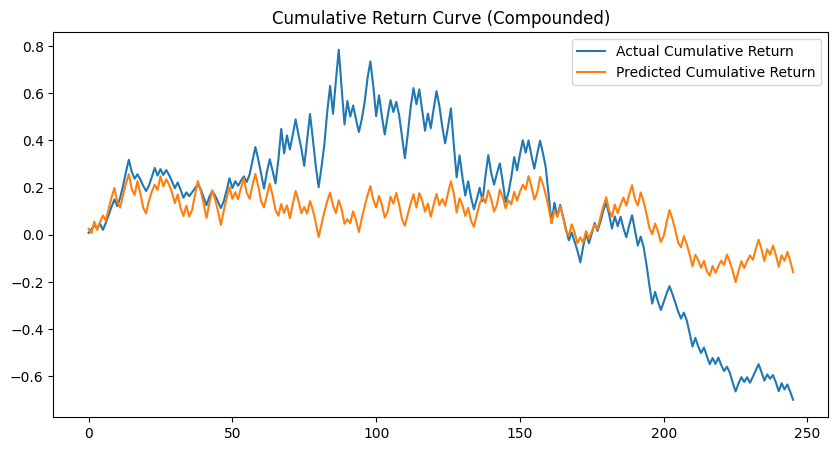

Cross-validated RMSE: 0.036282

===== MSFT =====


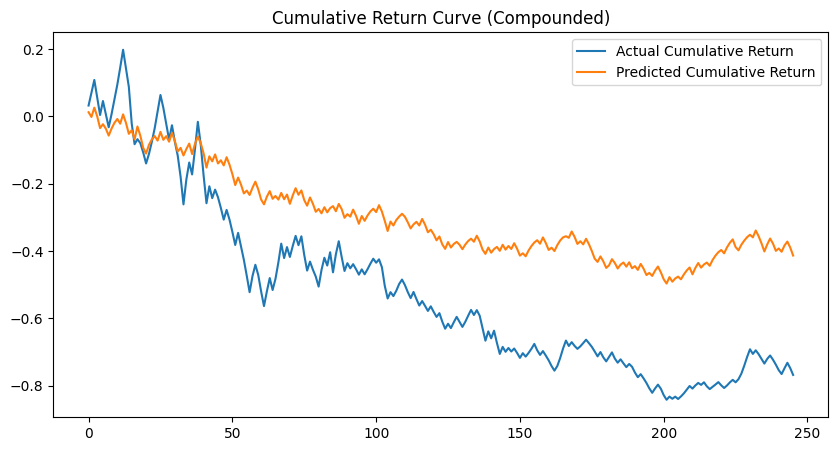

Cross-validated RMSE: 0.027626

===== AAPL =====


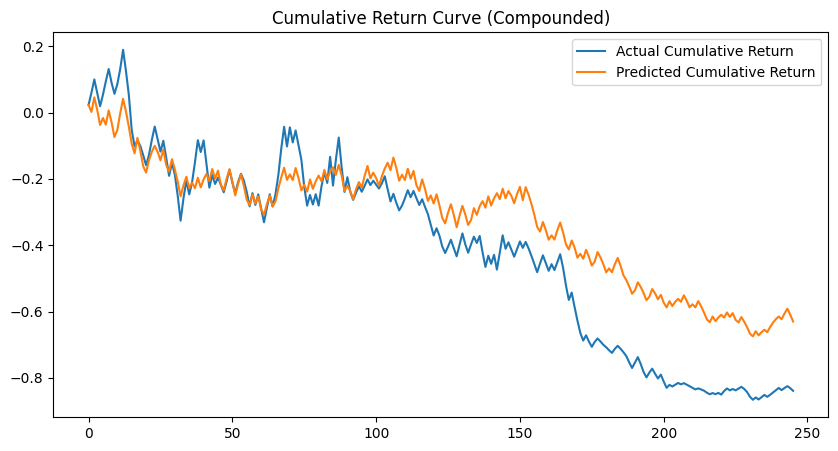

Cross-validated RMSE: 0.034288


In [9]:
# 線性回歸預測
from sklearn.linear_model import LinearRegression

for symbol, data in features.items():
    print(f"\n===== {symbol} =====")

    X = data["X"]
    y = data["y_regress"]

    split_idx = int(len(X) * 0.8)
    train_x, test_x = X[:split_idx], X[split_idx:]
    train_y, test_y = y[:split_idx], y[split_idx:]

    model = LinearRegression()

    regress_process(model, train_x, train_y, test_x, test_y)


===== TSLA =====


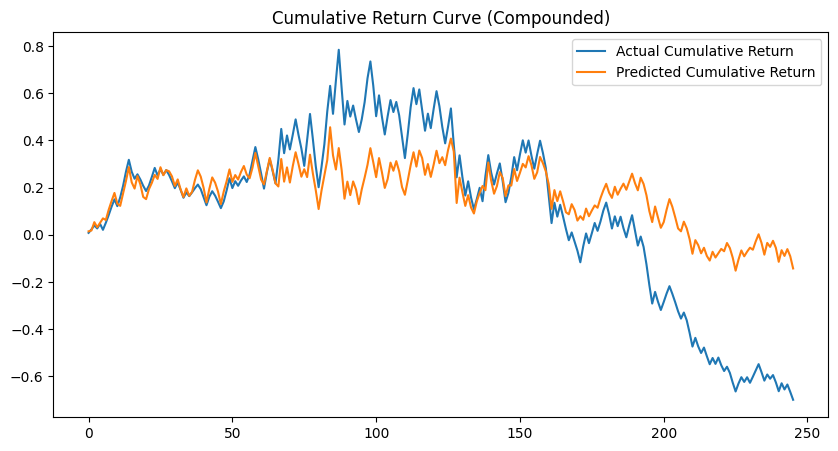

Cross-validated RMSE: 0.038553

===== MSFT =====


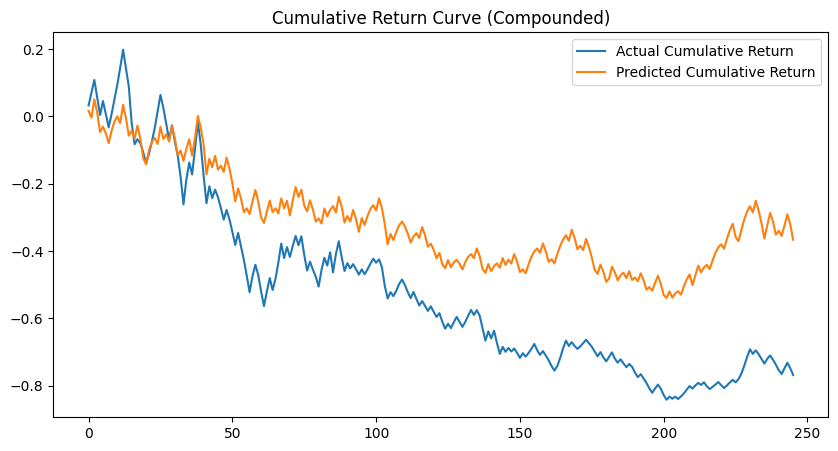

Cross-validated RMSE: 0.029028

===== AAPL =====


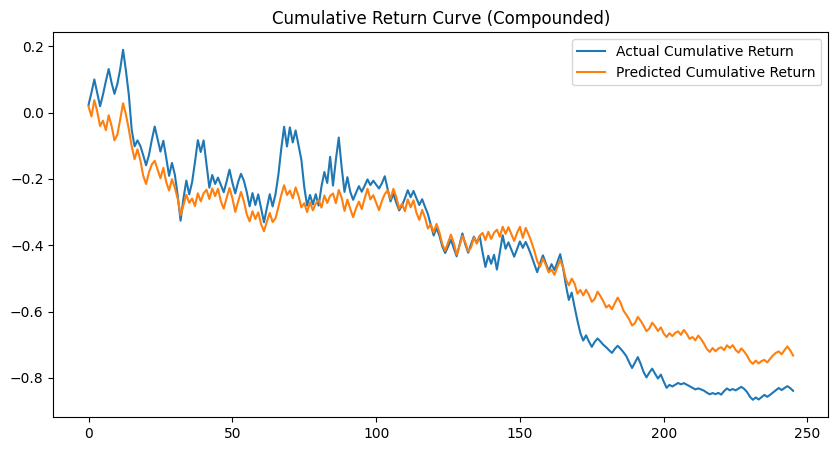

Cross-validated RMSE: 0.053612


In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_model = make_pipeline(
    PolynomialFeatures(degree=3),  # 幾次多項式可調
    LinearRegression()
)

# ✅ 用 Polynomial Regression 取代 LinearRegression
for symbol, data in features.items():
    print(f"\n===== {symbol} =====")

    X = data["X"]
    y = data["y_regress"]

    split_idx = int(len(X) * 0.8)
    train_x, test_x = X[:split_idx], X[split_idx:]
    train_y, test_y = y[:split_idx], y[split_idx:]

    model = make_pipeline(
        PolynomialFeatures(degree=2),
        LinearRegression()
    )

    regress_process(model, train_x, train_y, test_x, test_y)


===== TSLA =====


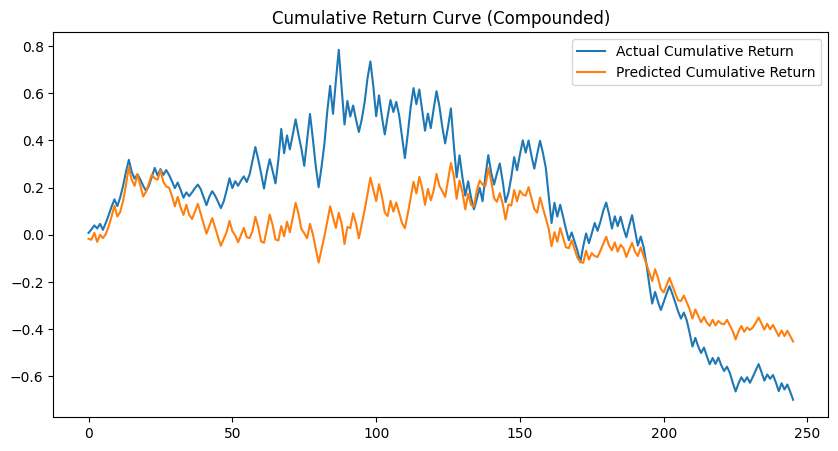

Cross-validated RMSE: 0.034753

===== MSFT =====


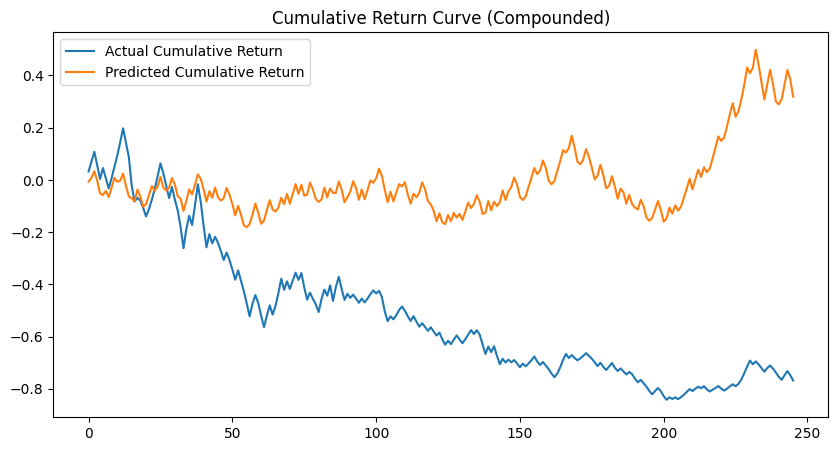

Cross-validated RMSE: 0.025490

===== AAPL =====


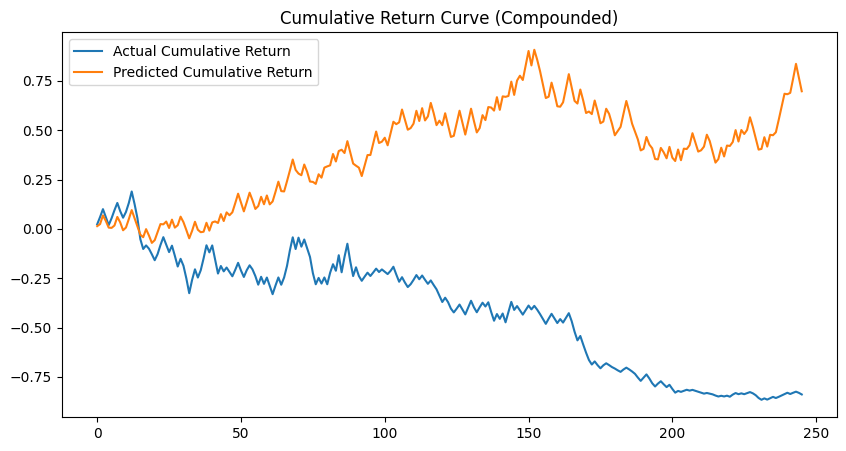

Cross-validated RMSE: 0.034612


In [11]:
# 用 AdaBoost 預測
from sklearn.ensemble import AdaBoostRegressor

for symbol, data in features.items():
    print(f"\n===== {symbol} =====")

    X = data["X"]
    y = data["y_regress"]
    
    split_idx = int(len(X) * 0.8)
    train_x, test_x = X[:split_idx], X[split_idx:]
    train_y, test_y = y[:split_idx], y[split_idx:]

    model = AdaBoostRegressor(n_estimators=100)

    regress_process(model, train_x, train_y, test_x, test_y)


===== TSLA =====


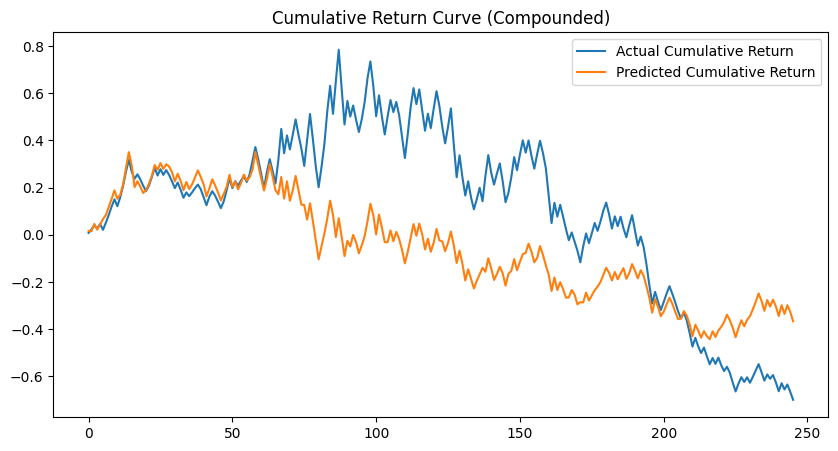

Cross-validated RMSE: 0.031714

===== MSFT =====


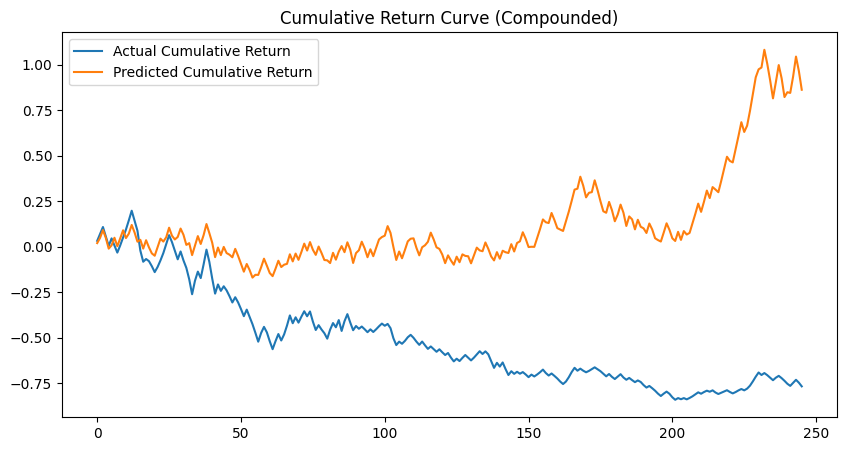

Cross-validated RMSE: 0.024505

===== AAPL =====


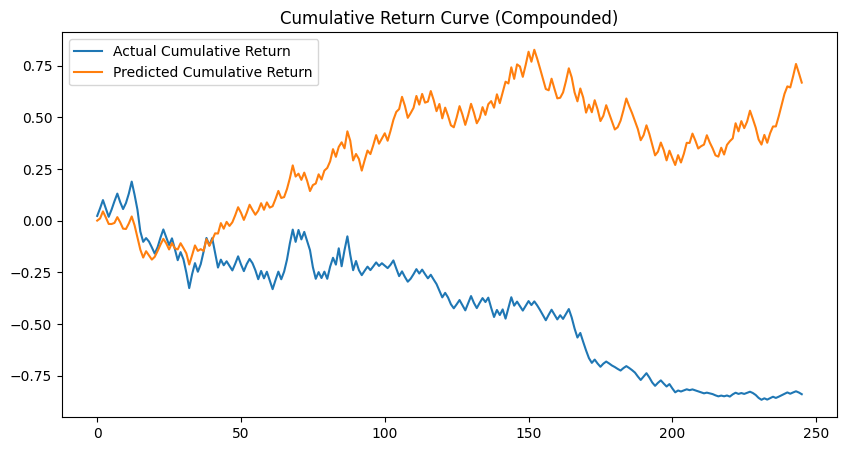

Cross-validated RMSE: 0.033117


In [12]:
# 隨機森林
from sklearn.ensemble import RandomForestRegressor

for symbol, data in features.items():
    print(f"\n===== {symbol} =====")

    X = data["X"]
    y = data["y_regress"]
    
    split_idx = int(len(X) * 0.8)
    train_x, test_x = X[:split_idx], X[split_idx:]
    train_y, test_y = y[:split_idx], y[split_idx:]

    model = RandomForestRegressor(n_estimators=100)

    regress_process(model, train_x, train_y, test_x, test_y)

# 用機器學習-分類演算法來預測股票漲跌

In [13]:
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import accuracy_score

def classification_process(estimator, train_x, train_y_cls, test_x, test_y_cls):

    # 訓練模型
    estimator.fit(train_x, train_y_cls)

    # 測試預測
    test_pred = estimator.predict(test_x)

    # 測試集準確率
    acc = accuracy_score(test_y_cls, test_pred)
    print(f"Test Accuracy = {acc:.2f}")

    # 時序交叉驗證（避免資訊洩漏）
    tscv = TimeSeriesSplit(n_splits=10)

    cv_scores = cross_val_score(
        estimator,
        train_x,
        train_y_cls,
        cv=tscv,
        scoring="accuracy"
    )

    print(f"TimeSeriesSplit CV Mean Accuracy = {cv_scores.mean():.2f}")

In [14]:
from sklearn.linear_model import LogisticRegression

for symbol, data in features.items():
    print(f"\n===== {symbol} =====")

    X = data["X"]
    y_cls = data["y_classification"]  # ✅ 已二元化漲跌

    # 訓練 / 測試切分（8:2）
    split_idx = int(len(X) * 0.8)
    train_x, test_x = X[:split_idx], X[split_idx:]
    train_y, test_y = y_cls[:split_idx], y_cls[split_idx:]

    clf = LogisticRegression(
        C=1.0,
        penalty="l2",   # L1 也可以，但需 solver="liblinear"
        max_iter=500
    )

    classification_process(clf, train_x, train_y, test_x, test_y)



===== TSLA =====
Test Accuracy = 0.92
TimeSeriesSplit CV Mean Accuracy = 0.92

===== MSFT =====
Test Accuracy = 0.89
TimeSeriesSplit CV Mean Accuracy = 0.92

===== AAPL =====
Test Accuracy = 0.91
TimeSeriesSplit CV Mean Accuracy = 0.93


In [15]:
for symbol, data in features.items():
    print(f"\n===== {symbol} =====")

    X = data["X"]
    y = data["y_classification"]

    # 8:2 時間序切割
    split_idx = int(len(X) * 0.8)
    train_x, test_x = X[:split_idx], X[split_idx:]
    train_y, test_y = y[:split_idx], y[split_idx:]

    # SVM 模型（RBF kernel）
    svm_clf = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", C=1.0, gamma="scale")  # 預設參數
    )

    classification_process(svm_clf, train_x, train_y, test_x, test_y)


===== TSLA =====
Test Accuracy = 0.92
TimeSeriesSplit CV Mean Accuracy = 0.89

===== MSFT =====
Test Accuracy = 0.89
TimeSeriesSplit CV Mean Accuracy = 0.86

===== AAPL =====
Test Accuracy = 0.91
TimeSeriesSplit CV Mean Accuracy = 0.90


In [16]:
from sklearn.ensemble import RandomForestClassifier

for symbol, data in features.items():
    print(f"\n===== {symbol} =====")

    X = data["X"]
    y = data["y_classification"]   # ✅ 漲跌標籤

    # 80% 訓練 + 20% 測試（時間序列切法）
    split_idx = int(len(X) * 0.8)
    train_x, test_x = X[:split_idx], X[split_idx:]
    train_y, test_y = y[:split_idx], y[split_idx:]

    # ✅ 隨機森林分類器
    model = RandomForestClassifier(
        n_estimators=300,
        max_depth=5,
        min_samples_split=20,
        random_state=42,
        n_jobs=-1
    )

    classification_process(model, train_x, train_y, test_x, test_y)



===== TSLA =====
Test Accuracy = 0.93
TimeSeriesSplit CV Mean Accuracy = 0.93

===== MSFT =====
Test Accuracy = 0.92
TimeSeriesSplit CV Mean Accuracy = 0.92

===== AAPL =====
Test Accuracy = 0.91
TimeSeriesSplit CV Mean Accuracy = 0.93


# 決策樹繪製

In [17]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pandas as pd
import os

def visualize_decision_tree(symbol, features_dict, max_depth=3):
    """
    訓練並輸出決策樹 PNG 圖檔

    symbol        → "TSLA", "AAPL" ...
    features_dict → 你之前產生 features 的字典
    max_depth     → 限制樹深度避免過擬合 & 更易閱讀
    """

    data = features_dict[symbol]

    X = data["X"]
    y = data["y_classification"]
    feature_names = data["feature_df"].columns[1:]  # 第一欄是 target(y)，跳過

    # 時間序列切分
    split_idx = int(len(X) * 0.8)
    train_x, test_x = X[:split_idx], X[split_idx:]
    train_y, test_y = y[:split_idx], y[split_idx:]

    # ✅ 建立決策樹（分類用）
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        random_state=42
    )

    # ✅ 訓練模型
    model.fit(train_x, train_y)

    # ✅ 匯出 Graphviz DOT 檔
    export_graphviz(
        model,
        out_file=f"data/{symbol}.dot",
        feature_names=feature_names,
        class_names=["Down", "Up"],
        filled=True,
        rounded=True,
        special_characters=True
    )

    # ✅ 將 .dot 轉成 PNG（需安裝 graphviz），路徑輸出在data/下面寫死了
    os.system(f"dot -Tpng data/{symbol}.dot -o data/{symbol}.png")

    print(f"✅ Decision tree saved as {symbol}.png")

In [18]:
visualize_decision_tree("TSLA", features, max_depth=3)
visualize_decision_tree("AAPL", features, max_depth=2)

✅ Decision tree saved as TSLA.png
✅ Decision tree saved as AAPL.png


In [19]:
# 找出特徵重要性
import pandas as pd

def feature_importance_df(estimator, feature_names):
    """
    回傳模型特徵重要度或權重（排序後）

    estimator     → 已 fit 過的模型
    feature_names → X 對應的欄位名稱 list
    """

    # ✅ Tree-based model (RandomForest, XGBoost, DecisionTree, ExtraTrees)
    if hasattr(estimator, "feature_importances_"):
        return (
            pd.DataFrame({
                "feature": feature_names,
                "importance": estimator.feature_importances_
            })
            .sort_values("importance", ascending=False)
            .reset_index(drop=True)
        )

    # ✅ Linear model (LogisticRegression, LinearRegression, SVM linear kernel)
    elif hasattr(estimator, "coef_"):
        return (
            pd.DataFrame({
                "feature": feature_names,
                "coef": estimator.coef_.ravel()
            })
            .sort_values("coef", ascending=False)
            .reset_index(drop=True)
        )

    else:
        raise ValueError("Model has neither feature_importances_ nor coef_")

In [20]:
from sklearn.ensemble import RandomForestClassifier

symbol = "AAPL"
data = features[symbol]

X = data["X"]
y = data["y_classification"]
feature_names = data["feature_df"].columns[1:]  # 排除 y 欄

# 訓練模型
model = RandomForestClassifier(n_estimators=100)
model.fit(X, y)

# 取得特徵重要度
importance = feature_importance_df(model, feature_names)
importance

,feature,importance
0,feature_sign,0.627107
1,feature_volume_Change,0.107252
2,feature_date_week,0.079489
3,feature_price_change,0.068097
4,feature_price_noise,0.059198
5,feature_volume_noise,0.058858


In [21]:
# 特徵篩選建議
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFE

def run_rfe_for_stocks(features_dict, estimator, n_features=5):
    """
    對多股票進行 RFE 特徵篩選

    features_dict : 你的 features 字典
                    {
                      "TSLA": {"X": ..., "y_regress": ..., "feature_df": ...},
                      ...
                    }
    estimator     : sklearn 模型（Logistic, RF, LinearRegression, SVM linear）
    n_features    : 想保留的特徵數
    """

    results = {}  # 儲存每檔股票 RFE 結果

    for symbol, data in features_dict.items():
        print(f"\n===== {symbol} RFE =====")

        X = data["X"]
        y = data["y_classification"]  # ✅ 使用分類版漲跌標籤
        feature_names = data["feature_df"].columns[1:]  # 排除 y

        selector = RFE(
            estimator,
            n_features_to_select=n_features,
            step=1
        )
        selector.fit(X, y)

        selected = feature_names[selector.support_]
        ranking = selector.ranking_

        df = pd.DataFrame({
            "feature": feature_names,
            "selected": selector.support_,
            "ranking": ranking
        }).sort_values("ranking")

        print(df)

        results[symbol] = {
            "selected_features": list(selected),
            "ranking_table": df
        }

    return results

In [22]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    random_state=42
)

rfe_results = run_rfe_for_stocks(
    features_dict=features,
    estimator=model,
    n_features=5   # ✅ 想保留 5 個最重要特徵
)


===== TSLA RFE =====
                 feature  selected  ranking
0   feature_price_change      True        1
1  feature_volume_Change      True        1
2           feature_sign      True        1
3      feature_date_week      True        1
4   feature_volume_noise      True        1
5    feature_price_noise     False        2

===== MSFT RFE =====
                 feature  selected  ranking
0   feature_price_change      True        1
1  feature_volume_Change      True        1
2           feature_sign      True        1
3      feature_date_week      True        1
4   feature_volume_noise      True        1
5    feature_price_noise     False        2

===== AAPL RFE =====
                 feature  selected  ranking
0   feature_price_change      True        1
1  feature_volume_Change      True        1
2           feature_sign      True        1
3      feature_date_week      True        1
4   feature_volume_noise      True        1
5    feature_price_noise     False        2


# 非監督式機器學習

# PCA降維可視化

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


def plot_classifier_decision_boundary(estimator, X, y, title="Decision Boundary"):
    """
    用 PCA 將高維特徵降為 2D 並繪製分類決策邊界
    """

    # ✅ Step1：降維到 2D（方便畫圖）
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    # ✅ Step2：訓練模型
    estimator.fit(X_2d, y)

    # ✅ Step3：建立畫圖網格
    x_min, x_max = X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5
    y_min, y_max = X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    # ✅ Step4：模型預測網格分類
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = estimator.predict(grid).reshape(xx.shape)

    # ✅ Step5：畫 decision boundary + 點
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="coolwarm", s=30, edgecolors="k")

    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()


def plot_all_models(symbol, X, y):
    """
    一次繪製三種模型的決策邊界
    """

    models = [
        ("Logistic Regression", LogisticRegression(max_iter=500)),
        ("SVM (RBF Kernel)", SVC(kernel="rbf", C=1, probability=True)),
        ("Random Forest", RandomForestClassifier(n_estimators=200))
    ]

    for name, model in models:
        print(f"✅ {symbol} → {name}")
        plot_classifier_decision_boundary(model, X, y, title=f"{symbol} - {name}")

✅ AAPL → Logistic Regression


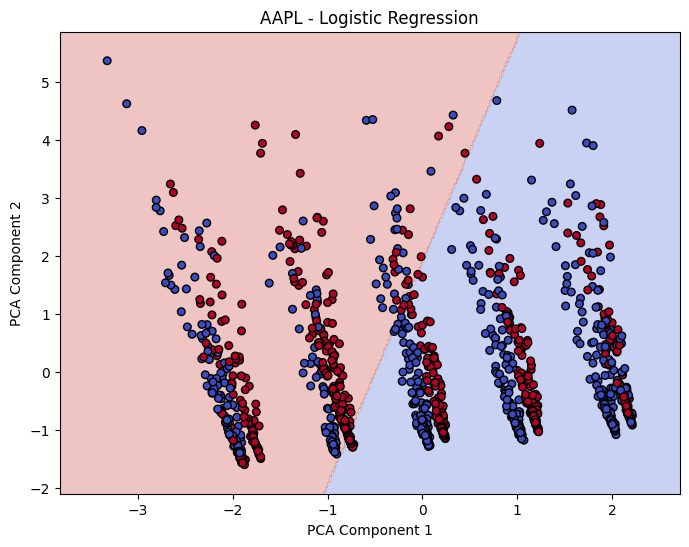

✅ AAPL → SVM (RBF Kernel)


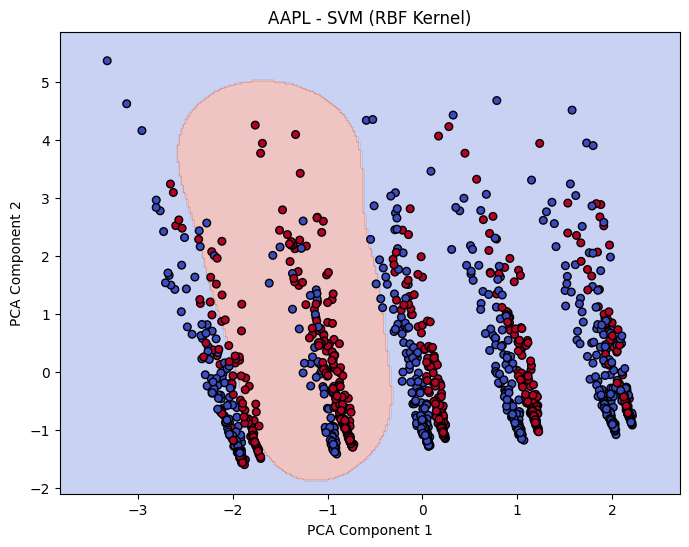

✅ AAPL → Random Forest


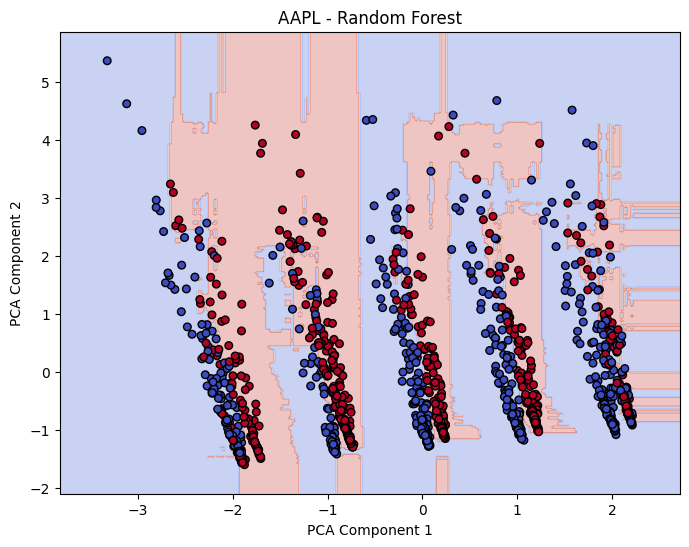

In [24]:
# for symbol, data in features.items():
#     X = data["X"]
#     y = data["y_classification"]

#     plot_all_models(symbol, X, y)

symbol = "AAPL"
data = features[symbol]
X = data["X"]
y = data["y_classification"]

plot_all_models(symbol, X, y)

# 利用分群演算法做模型診斷

In [25]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

def kmeans_prediction_diagnostics(feature_df, y_true, y_pred):
    """
    用 KMeans 判斷模型在哪些市場情況表現較好/較差

    feature_df → 你的 feature_df（包含 feature_date_week）
    y_true     → 真實漲跌分類 (0/1)
    y_pred     → 模型預測漲跌分類 (0/1)

    return → DataFrame，含：
        y_same → 是否預測正確
        cluster → KMeans 分群
        feature_date_week → 星期幾
    """

    df = feature_df.copy()

    # ✅ 標示是否預測正確
    df["y_same"] = np.where(y_true == y_pred, 1, 0)

    # ✅ 只用 y_same 當聚類輸入
    x_kmeans = df[["y_same"]].values

    kmeans = KMeans(n_clusters=2, random_state=42)
    df["cluster"] = kmeans.fit_predict(x_kmeans)

    return df[["y_same", "cluster", "feature_date_week"]]

In [26]:
symbol = "TSLA"
data = features[symbol]

X = data["X"]
y = data["y_classification"]

# split
split = int(len(X) * 0.8)
train_x, test_x = X[:split], X[split:]
train_y, test_y = y[:split], y[split:]

# train classifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200)
model.fit(train_x, train_y)

# predict
test_pred = model.predict(test_x)

# KMeans 診斷
diagnostics = kmeans_prediction_diagnostics(
    data["feature_df"].iloc[split:],  # test feature_df
    test_y,
    test_pred
)

diagnostics.tail()

Price,y_same,cluster,feature_date_week
Date,,,
2025-11-17,1,0,0
2025-11-18,1,0,1
2025-11-19,1,0,2
2025-11-20,1,0,3
2025-11-21,1,0,4


In [27]:
pd.crosstab(
    diagnostics.feature_date_week,
    diagnostics.cluster,
)

cluster,0,1
feature_date_week,,
0,38,9
1,51,0
2,49,0
3,49,0
4,43,7
